In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import mlflow
import mlflow.pytorch
import wandb
import os
from dotenv import load_dotenv
from pathlib import Path

# Import comprehensive logging utilities (now all in one file)
from logging_utils import *

In [2]:
import ale_py
gym.register_envs(ale_py)

In [3]:
# Reproducibility
SEED = 14127 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set to: {SEED}")

Random seed set to: 14127


In [4]:
class ConvDQN(nn.Module):
    def __init__(self, input_channels, action_size):
        super(ConvDQN, self).__init__()
        
        # Optimized architecture: 32→36→20 filters (vs original 32→64→64)
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 36, kernel_size=4, stride=2, padding=1),  # Reduced from 64 to 36
            nn.ReLU(),
            nn.Conv2d(36, 20, kernel_size=3, stride=1, padding=1),  # Reduced from 64 to 20
            nn.ReLU()
        )
        
        # Calculate correct feature size dynamically
        self.feature_size = self._get_conv_output_size()
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def _get_conv_output_size(self):
        """Calculate the output size of conv layers"""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 84, 84)  # 1 batch size, 2 channels, 84x84
            conv_output = self.conv(dummy_input)
            return conv_output.numel() // conv_output.size(0)  # Flatten size per sample
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), action, reward, np.array(next_state), done
    
    def __len__(self):
        return len(self.buffer)

def preprocess_frame(frame):
    import cv2
    gray = np.mean(frame, axis=2).astype(np.uint8)
    cropped = gray[34:194, :]
    resized = cv2.resize(cropped, (84, 84), interpolation=cv2.INTER_AREA)
    return resized.astype(np.float32) / 255.0

class FrameStack:
    def __init__(self, num_frames=2):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self, frame):
        processed_frame = preprocess_frame(frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return self.get_stacked()
    
    def step(self, frame):
        processed_frame = preprocess_frame(frame)
        self.frames.append(processed_frame)
        return self.get_stacked()
    
    def get_stacked(self):
        return np.stack(list(self.frames), axis=0)

In [5]:
# Global hyperparameters
LEARNING_RATE = 0.0001
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 32
BUFFER_SIZE = 100000
TARGET_UPDATE = 1000
MEAN_REWARD_BOUND = 19.5  # Changed from MAX_REWARD_BOUND to MEAN_REWARD_BOUND
FRAME_SKIP = 4
INPUT_CHANNELS = 2
FRAME_STACK = 2

# Unified logging frequency - Enhanced monitoring configuration
LOG_FREQ = 100  # Log comprehensive analysis every 100 episodes
GRADIENT_LOG_FREQ = 500  # Log gradients every 500 steps

# Architecture version for tracking
ARCHITECTURE_NAME = "CNN-DQN-v2"
ARCHITECTURE_TYPE = "v2"  # "v2" for 32-36-20 optimized architecture
MODEL_FILTERS = "32-36-20"  # vs original "32-64-64"

# Setup hyperparameters dictionary - SINGLE SOURCE OF TRUTH
HYPERPARAMETERS = {
    "seed": SEED,
    "learning_rate": LEARNING_RATE,
    "gamma": GAMMA,
    "epsilon_start": EPSILON_START,
    "epsilon_min": EPSILON_MIN,
    "epsilon_decay": EPSILON_DECAY,
    "batch_size": BATCH_SIZE,
    "buffer_size": BUFFER_SIZE,
    "target_update": TARGET_UPDATE,
    "mean_reward_bound": MEAN_REWARD_BOUND,  # Updated key name
    "frame_skip": FRAME_SKIP,
    "input_channels": INPUT_CHANNELS,
    "frame_stack": FRAME_STACK,
    "architecture": ARCHITECTURE_NAME,
    "model_filters": MODEL_FILTERS,
    "architecture_type": ARCHITECTURE_TYPE,
    # Enhanced logging configuration
    "log_freq": LOG_FREQ,
    "gradient_log_freq": GRADIENT_LOG_FREQ,
    "comprehensive_monitoring": True,
    "weight_bias_analysis": True
}

# Set up directories for artifacts using relative paths
RL_STUDY_DIR = Path(__file__).resolve().parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
MLFLOW_TRACKING_URI = RL_STUDY_DIR / 'mlruns'
WANDB_DIR = RL_STUDY_DIR / 'wandb'
BASE_ARTIFACTS_DIR = RL_STUDY_DIR / 'artifacts'

# Configure MLflow to use local tracking
mlflow.set_tracking_uri(f'file://{MLFLOW_TRACKING_URI}')

# Configure wandb to use local directory
os.environ['WANDB_DIR'] = str(WANDB_DIR)
WANDB_DIR.mkdir(exist_ok=True)
BASE_ARTIFACTS_DIR.mkdir(exist_ok=True)
MLFLOW_TRACKING_URI.mkdir(exist_ok=True)

# Initialize wandb with unified project name
load_dotenv(RL_STUDY_DIR / '.env')
wandb_key = os.getenv('WANDB_KEY')
wandb.login(key=wandb_key)

wandb.init(
    project="pong_dqn_training",  # Unified project name same as v1
    name="pong_cnn_dqn_v2_optimized",
    dir=str(WANDB_DIR),
    config=HYPERPARAMETERS  # Use single source of truth
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/bmartins/.netrc
wandb: Currently logged in as: bmartins to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
# HYPERPARAMETERS now defined in cell-3 as single source of truth
# All comprehensive logging functions imported from logging_utils.py

In [7]:
# All weight visualization and analysis functions are now imported from logging_utils.py
# This includes all enhanced weight/bias logging, comprehensive analysis, and visualization functions

In [8]:
def train_dqn():
    # End any active runs first
    if mlflow.active_run():
        mlflow.end_run()
    
    # MLflow experiment setup - unified with wandb name
    mlflow.set_experiment("pong_dqn_training")
    
    with mlflow.start_run():
        # Create artifacts directory using MLflow run ID and rl_study structure
        run_id = mlflow.active_run().info.run_id
        artifacts_dir = BASE_ARTIFACTS_DIR / f"run_{run_id}"
        artifacts_dir.mkdir(parents=True, exist_ok=True)
        print(f"Artifacts will be saved to: {artifacts_dir}")
        
        env = gym.make('PongNoFrameskip-v4')
        env.reset(seed=SEED)  # Set seed for environment
        
        # Use global hyperparameters
        action_size = env.action_space.n
        lr = LEARNING_RATE
        gamma = GAMMA
        epsilon = EPSILON_START
        epsilon_min = EPSILON_MIN
        epsilon_decay = EPSILON_DECAY
        batch_size = BATCH_SIZE
        buffer_size = BUFFER_SIZE
        target_update = TARGET_UPDATE
        mean_reward_bound = MEAN_REWARD_BOUND  # Updated variable name
        frame_skip = FRAME_SKIP
        
        # Log hyperparameters using external function
        log_hyperparameters(str(artifacts_dir), HYPERPARAMETERS)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        
        main_net = ConvDQN(input_channels=INPUT_CHANNELS, action_size=action_size).to(device)
        target_net = ConvDQN(input_channels=INPUT_CHANNELS, action_size=action_size).to(device)
        target_net.load_state_dict(main_net.state_dict())
        
        # Setup enhanced weight tracking using logging utils
        setup_weight_tracking(main_net, log_freq=GRADIENT_LOG_FREQ, log_all=True)
        
        # Log model info using external function
        total_params = log_model_info(main_net, device, ARCHITECTURE_NAME)
        
        optimizer = optim.Adam(main_net.parameters(), lr=lr)
        buffer = ReplayBuffer(buffer_size)
        
        episode_rewards = []
        mean_rewards = []
        episode = 0
        total_steps = 0
        
        while True:
            state, _ = env.reset()
            frame_stack = FrameStack(FRAME_STACK)
            stacked_state = frame_stack.reset(state)
            total_reward = 0
            done = False
            step_count = 0
            episode_losses = []
            
            while not done:
                if random.random() > epsilon:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(stacked_state).unsqueeze(0).to(device)
                        q_values = main_net(state_tensor)
                        action = q_values.max(1)[1].item()
                else:
                    action = env.action_space.sample()
                
                step_reward = 0
                for _ in range(frame_skip):
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    step_reward += reward
                    if terminated or truncated:
                        break
                
                done = terminated or truncated
                next_stacked_state = frame_stack.step(next_state)
                
                buffer.push(stacked_state, action, step_reward, next_stacked_state, done)
                stacked_state = next_stacked_state
                total_reward += step_reward
                step_count += 1
                total_steps += 1
                
                if len(buffer) > batch_size:
                    states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                    
                    states = torch.FloatTensor(states).to(device)
                    actions = torch.LongTensor(actions).to(device)
                    rewards = torch.FloatTensor(rewards).to(device)
                    next_states = torch.FloatTensor(next_states).to(device)
                    dones = torch.BoolTensor(dones).to(device)
                    
                    current_q_values = main_net(states).gather(1, actions.unsqueeze(1))
                    
                    with torch.no_grad():
                        next_q_values = target_net(next_states).max(1)[0]
                        target_q_values = rewards + (gamma * next_q_values * ~dones)
                    
                    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
                    episode_losses.append(loss.item())
                    
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(main_net.parameters(), max_norm=10)
                    optimizer.step()
                    
                    # Enhanced gradient logging
                    if total_steps % GRADIENT_LOG_FREQ == 0:
                        log_training_step(loss.item(), episode, step_count)
                        log_layer_wise_gradient_norms(main_net, total_steps)
                        
                        # Log weight and bias norms during training
                        current_weight_norms = {}
                        current_bias_norms = {}
                        for name, param in main_net.named_parameters():
                            if param.requires_grad:
                                if 'bias' in name:
                                    current_bias_norms[f"bias_norms/{name}"] = param.data.norm().item()
                                else:
                                    current_weight_norms[f"weight_norms/{name}"] = param.data.norm().item()
                        
                        wandb.log({
                            **current_weight_norms,
                            **current_bias_norms,
                            "training/total_steps": total_steps,
                            "training/episode": episode
                        }, step=total_steps)
                
            if episode % target_update == 0:
                target_net.load_state_dict(main_net.state_dict())
            
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            episode_rewards.append(total_reward)
            mean_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            
            # Log episode metrics with loss information - using total_steps
            episode_loss_avg = np.mean(episode_losses) if episode_losses else 0.0
            log_episode_metrics(total_reward, mean_reward, epsilon, len(buffer), step_count, episode, step=total_steps)
            wandb.log({
                "episode/avg_loss": episode_loss_avg,
                "episode/num_training_steps": len(episode_losses)
            }, step=total_steps)

            # Debug line to check epsilon logging - using total_steps
            wandb.log({"debug/epsilon_direct": epsilon}, step=total_steps)
            
            # Basic weight logging every LOG_FREQ episodes - using total_steps
            if episode % LOG_FREQ == 0 and episode > 0:
                wandb.log({"weight_logging_episode": episode}, step=total_steps)
                log_weight_stats(model=main_net, episode=total_steps)
            
            # Check stopping condition: mean reward instead of max reward
            if mean_reward >= mean_reward_bound:
                max_reward_so_far = max(episode_rewards) if episode_rewards else 0
                print(f"Environment solved in {episode} episodes! Mean reward: {mean_reward:.2f} >= {mean_reward_bound}")
                print(f"Max reward achieved: {max_reward_so_far:.2f}")
                wandb.log({"solved_at_episode": episode}, step=total_steps)
                break
            
            # Save training plot every 1000 episodes
            if episode > 0 and episode % 1000 == 0:
                save_training_plot(str(artifacts_dir), episode_rewards, episode, mean_reward_bound, " v2")
            
            # Display plot every 100 episodes
            if episode % 100 == 0 and episode > 0:
                avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
                max_reward_so_far = max(episode_rewards) if episode_rewards else 0
                mean_rewards.append(avg_reward)
                print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Mean Reward (100): {mean_reward:.2f}, Max Reward: {max_reward_so_far:.2f}, Epsilon: {epsilon:.3f}, Buffer: {len(buffer)}, Total Steps: {total_steps}")
                
                display_training_plot(episode_rewards, mean_reward_bound, " v2")
            
            # Print progress every 10 episodes
            elif episode % 10 == 0 and episode > 0:
                avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
                max_reward_so_far = max(episode_rewards) if episode_rewards else 0
                print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Mean Reward (100): {mean_reward:.2f}, Max Reward: {max_reward_so_far:.2f}, Epsilon: {epsilon:.3f}, Buffer: {len(buffer)}, Total Steps: {total_steps}")
                
                wandb.log({"avg_reward_10": avg_reward}, step=total_steps)

            # Save checkpoint every 10000 episodes
            if episode % 10000 == 0:
                save_checkpoint(str(artifacts_dir), episode, main_net, optimizer, episode_rewards, epsilon, run_id, "pong_dqn_cnn_v2")

            episode += 1
        
        # Log final results
        final_model_path = log_final_results(main_net, episode, mean_reward, episode_rewards, str(artifacts_dir), run_id, "final_pong_dqn_cnn_v2")
        
        print(f"Training completed! All artifacts saved in: {artifacts_dir}")
        print(f"Total steps taken: {total_steps}")
        
        env.close()
        wandb.finish()
        return main_net

In [9]:
# Test optimized CNN architecture and compare with original
env = gym.make('PongNoFrameskip-v4')
state, _ = env.reset()

print(f"Original frame shape: {state.shape}")

processed = preprocess_frame(state)
print(f"Processed frame shape: {processed.shape}")

frame_stack = FrameStack(2)
stacked = frame_stack.reset(state)
print(f"Stacked frames shape: {stacked.shape}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_net_v2 = ConvDQN(input_channels=2, action_size=env.action_space.n).to(device)

with torch.no_grad():
    state_tensor = torch.FloatTensor(stacked).unsqueeze(0).to(device)
    q_values = cnn_net_v2(state_tensor)
    print(f"Network input shape: {state_tensor.shape}")
    print(f"Q-values shape: {q_values.shape}")
    print(f"Q-values: {q_values.cpu().numpy()}")

# Calculate and compare parameters
total_params_v2 = sum(p.numel() for p in cnn_net_v2.parameters())
conv_params_v2 = sum(p.numel() for name, p in cnn_net_v2.named_parameters() if 'conv' in name)
fc_params_v2 = sum(p.numel() for name, p in cnn_net_v2.named_parameters() if 'fc' in name)

print(f"\n=== OPTIMIZED MODEL (v2) ===")
print(f"Architecture: {ARCHITECTURE_NAME}")
print(f"Filter configuration: {MODEL_FILTERS}")
print(f"Total parameters: {total_params_v2:,}")
print(f"Conv parameters: {conv_params_v2:,} ({conv_params_v2/total_params_v2*100:.1f}%)")
print(f"FC parameters: {fc_params_v2:,} ({fc_params_v2/total_params_v2*100:.1f}%)")
print(f"Model size: {total_params_v2 * 4 / (1024*1024):.2f} MB")

# Original model comparison (from original training)
original_params = 3354278  # From original training
reduction_pct = (original_params - total_params_v2) / original_params * 100

print(f"\n=== COMPARISON WITH ORIGINAL ===")
print(f"Original parameters: {original_params:,}")
print(f"Optimized parameters: {total_params_v2:,}")
print(f"Parameter reduction: {original_params - total_params_v2:,} ({reduction_pct:.1f}%)")
print(f"Expected speedup: {original_params / total_params_v2:.1f}x")

env.close()

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Original frame shape: (210, 160, 3)
Processed frame shape: (84, 84)
Stacked frames shape: (2, 84, 84)
Network input shape: torch.Size([1, 2, 84, 84])
Q-values shape: torch.Size([1, 6])
Q-values: [[ 0.04669337  0.03550746  0.03729591 -0.02613549 -0.02200529  0.02676901]]

=== OPTIMIZED MODEL (v2) ===
Architecture: CNN-DQN-v2
Filter configuration: 32-36-20
Total parameters: 1,056,686
Conv parameters: 29,096 (2.8%)
FC parameters: 1,027,590 (97.2%)
Model size: 4.03 MB

=== COMPARISON WITH ORIGINAL ===
Original parameters: 3,354,278
Optimized parameters: 1,056,686
Parameter reduction: 2,297,592 (68.5%)
Expected speedup: 3.2x


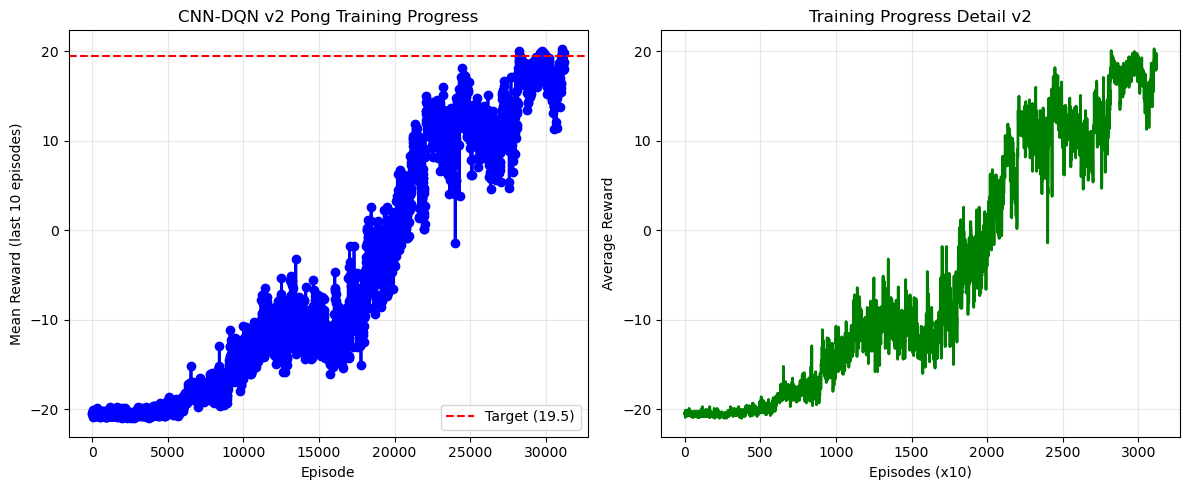

Episode 31210, Avg Reward: 18.50, Mean Reward (100): 18.61, Max Reward: 21.00, Epsilon: 0.010, Buffer: 100000, Total Steps: 82241970
Episode 31220, Avg Reward: 19.40, Mean Reward (100): 18.61, Max Reward: 21.00, Epsilon: 0.010, Buffer: 100000, Total Steps: 82259983
Episode 31230, Avg Reward: 17.90, Mean Reward (100): 18.56, Max Reward: 21.00, Epsilon: 0.010, Buffer: 100000, Total Steps: 82278854
Episode 31240, Avg Reward: 20.50, Mean Reward (100): 18.76, Max Reward: 21.00, Epsilon: 0.010, Buffer: 100000, Total Steps: 82295794
Episode 31250, Avg Reward: 19.90, Mean Reward (100): 18.98, Max Reward: 21.00, Epsilon: 0.010, Buffer: 100000, Total Steps: 82313280
Episode 31260, Avg Reward: 19.30, Mean Reward (100): 19.07, Max Reward: 21.00, Epsilon: 0.010, Buffer: 100000, Total Steps: 82331183
Episode 31270, Avg Reward: 20.10, Mean Reward (100): 19.23, Max Reward: 21.00, Epsilon: 0.010, Buffer: 100000, Total Steps: 82348284
Episode 31280, Avg Reward: 20.50, Mean Reward (100): 19.29, Max Rewar

2025/10/10 12:53:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Environment solved in 31292 episodes! Mean reward: 19.50 >= 19.5
Max reward achieved: 21.00


2025/10/10 12:53:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.10.0.dev20250930+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.10.0.dev20250930' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/10 12:53:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.10.0.dev20250930+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.10.0.dev20250930' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/10 12:53:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training completed! All artifacts saved in: /home/bmartins/dev/rl_study/artifacts/run_19ced322175f4bcd886ed9089e5bff78
Total steps taken: 82386085


avg_reward_10,▁▁▁▁▁▁▁▁▁▂▂▂▂▃▂▃▃▄▃▃▃▂▂▃▃▄▄▅▆▆▇▆▇▇▆▇█▇██
bias_norms/conv.0.bias,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
bias_norms/conv.2.bias,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
bias_norms/conv.4.bias,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▆▆▆▆▆▇▇▇▇█
bias_norms/fc.0.bias,▁▁▁▁▂▂▃▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
bias_norms/fc.2.bias,▁▂▃▃▄▅▅▅▄▄▄▄▄▃▃▂▃▂▂▃▃▂▃▃▃▄▄▄▄▄▆▇▇▇▇▇███▇
debug/epsilon_direct,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode/avg_loss,▁▁▁▁▁▂▂▂▁▁▂▂▃▃▃▄▄▄▅▆▆▅█▆▅▆▆▅▅▄▄▄▅▅▄▂▃▂▃▂
episode/num_training_steps,▁▁▁▁▁▁▁▂▂▃▂▂▂▅▅▆▆▇▅▇▇▅▅▆▅██▇▆▆▅▅▅▅▅▄▆▃▃▃
final_episode,▁
final_mean_reward,▁


CNN-DQN Training completed!


In [10]:
# Ensure no active MLflow runs before training
if mlflow.active_run():
    print("Ending active MLflow run...")
    mlflow.end_run()

# Train the CNN-based DQN
trained_model = train_dqn()
print("CNN-DQN Training completed!")